# Distribuciones mixtas - discreta + continua
***

_Autor:_    __Jesús Casado__ <br> _Revisión:_ __09/03/2020__ <br>

__Introducción__<br>


__Cosas que arreglar__ <br>


__Índice__ <br>

__[Cargar datos](#Cargar-datos)__ <br>

__[Serie de máximos anuales](#Serie-de-máximos-anuales)__ <br>

__[Peak over threshold](#Peak-over-threshold)__<br>
[Selección de eventos](#Selección-de-eventos)<br>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()

import pomegranate as pg

import os
rutaBase = os.getcwd().replace('\\', '/') + '/'

In [2]:
from scipy import stats

In [3]:
from fitter import Fitter

In [4]:
%run POT_funciones.ipynb

In [13]:
class mixedDistributionDC:
    """Distribución mixta para variables siempre positivas (x >= 0) en la que se descompone en
    dos distribuciones, una discreta que modela la probabilidad de que la variable sea 0, y una
    continua que modela la magnitud de la variable en caso de ser mayor que 0.
    """
    
    def __init__(self, data):
        """
        Parámetro:
        ----------
        data:    array(n,). Valores de la variable de estudio
        
        Salida:
        -------
        Po:    float. Probabilidad de que la variable positiva tome el valor 0
        """
        
        self.data = data
        # probabilidad de 0
        self.Po = np.sum(data == 0) / len(data)
        
    def fit(self, distrs, crit):
        """Ajusta la función de distribución más apropiada a los datos en base al criterio definido
        
        Parámetros:
        -----------
        distrs:    list of strings. Lista con el nombre de SciPy de las distribuciones a ajustar
        crit:      string. Criterio en función del que seleccionar la mejor distribución: 'sumsquare_error'; 'aic' criterio de Akaike; 'bic', criteiro bayesiano
        
        Salidas:
        --------
        distr:      callable. Función de distribución de SciPy que mejor se ajusta a los datos
        fitResults: data frame. Tabla con los resultados de la bondad del ajuste para cada distribución
        pars:       list of floats. Parámetros ajustados para 'distr'
        """
        
        # datos con valor positivo
        data_ = self.data[self.data > 0]

        # buscar distribución con mejor rendimiento
        F = Fitter(data_, distributions=distrs, verbose=False)
        F.fit()
        F.summary()
        results = F.summary().sort_values(crit)
        self.fitResults = results

        # extraer la distribución con menor AIC (criterio de información de Akaike)
        distStr = results.index[0]
        distr = getattr(stats, distStr)
        pars = F.fitted_param[distStr]
        self.model = distr(*pars)
        
    def cdf(self, x):
        """Función de distribución acumulada
                CDFtotal = Po + (1 - Po) * CDFpositivos
                
        Parámetros:
        -----------
        x:         array (m). Valores de la variable
        
        Salida:
        -------
        cdf:       array (m). Probabilidad de no excedencia asociada a los valores de 'x'
        """
        
        # asegurar que 'x' es un array
        if isinstance(x, int) | isinstance(x, float):
            x = np.array([x]).astype(float)
        elif isinstance(x, list):
            x = np.array(x).astype(float)

        # 'array' donde guardar la probabilidad acumulada
        cdf = self.Po + (1 - self.Po) * self.model.cdf(x)
        
        return cdf
    
    def pdf(self, x):
        """
        """
        
        # asegurar que 'x' es un array
        if isinstance(x, int) | isinstance(x, float):
            x = np.array([x]).astype(float)
        elif isinstance(x, list):
            x = np.array(x).astype(float)
            
        # calcular la probabilidad de los valores de 'x'
        pdf = self.model.pdf(x)
        pdf[x == 0] = self.Po

        return pdf
    
    def ppf(self, q):
        """
        """
        
        # asegurar que 'q' es un array
        if isinstance(q, int) | isinstance(q, float):
            q = np.array([q]).astype(float)
        elif isinstance(x, list):
            q = np.array(q).astype(float)
            
        # comprobar que todos los valores de 'q' son correctos
        if (any(q < 0)) | (any(q > 1)):
            print('ERROR. Valores de "q" erróneos.')
            
        # calcular el cuantil de los valores de 'q'
        ppf = np.zeros_like(q)
        ppf[q > self.Po] = self.model.ppf((q[q > self.Po] - self.Po) / (1 - self.Po))
        
        return ppf
    
        

## Cargar datos

In [14]:
data = pd.read_csv(rutaBase + '../data/Serie_extremos_marginal_P.csv', parse_dates=True,
                   index_col=0)
data.head()

Nivel  Precipitacion
fecha                           
1981-01-01   4.40            0.0
1982-01-01   7.76            0.0
1983-01-01   9.01            0.0
1984-01-01   5.55            0.0
1985-01-01   6.95            0.0

In [15]:
# Extraer serie de precipitación
P = data.Precipitacion.values

# Serie de días con precipitación
P_ = P[P > 0].copy()

sumsquare_error          aic       bic  kl_div
pearson3           1.321552   852.647067 -8.166751     inf
gamma              1.319922   889.592314 -8.176627     inf
genpareto          1.312084   908.328063 -8.224273     inf
genextreme         1.325848   922.147942 -8.140792     inf
beta               1.318998  1111.056430 -6.102787     inf

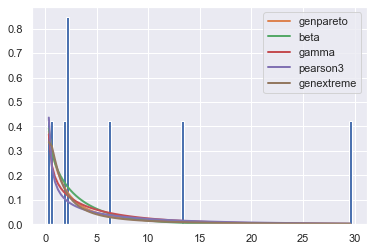

In [16]:
# declarar la distribución mixta
mdP = mixedDistributionDC(P)

# ajustar la distribución continua
distribuciones = ['beta', 'expon', 'weibull_min', 'gamma', 'genextreme', 'genpareto',
                  'gumbel_r', 'norm', 'weibull_max', 'pearson3']
mdP.fit(distribuciones, 'aic')
mdP.fitResults

In [17]:
# calcular la cdf
Pmax = np.ceil(data.Precipitacion.max() / 10) * 10
x = np.concatenate(([0], np.linspace(1e-10, Pmax)))
cdf = mdP.cdf(x)

# calcular la pdf
pdf = mdP.pdf(x)

In [18]:
# distribución empírica
ecdfP_ = ECDF(P_)
ecdfs = mdP.Po + (1 - mdP.Po) * ecdfP_(P_)

In [19]:
# ppf
q_ = np.linspace(0, 1, 1000)
x_ = mdP.ppf(q_)

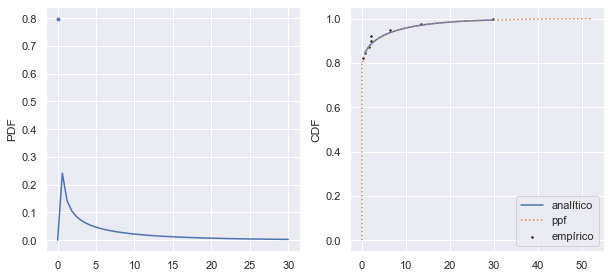

In [23]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4.5))

ax[0].scatter(x[0], pdf[0], s=8, label='analítico')
ax[0].plot(x[1:], pdf[1:], label='analítico')
ax[0].set(ylabel='PDF')

ax[1].plot(x, cdf, label='analítico')
ax[1].plot(x_, q_, label='ppf', ls=':')
ax[1].scatter(P_, ecdfs, s=2, c='k', label='empírico')
ax[1].set(ylabel='CDF')
ax[1].legend();